In [1]:
import sys
sys.path.append("scripts/")
from GridMap import *
import math
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class Dijkstra():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.cost_map = np.full(self.grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.grid_map.shape, 0)
        self.isopen_map = np.full(self.grid_map.shape, 0)
        self.parent_id_map = np.full(self.grid_map.shape, 0)
        self.evaluate_map = np.full(self.grid_map.shape, 100000)    #スタートからのコスト
        self.evaluate_finish_map = np.full(self.grid_map.shape, 100000)
        self.flag_path_draw = 0  #経路描画のフラグ
        
        self.grids = []
        
        index = 0
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = index;
                if(grid == '2'):
                    self.evaluate_map[index_x][index_y] = 0
                index += 1                    

    def append_grids(self, grid):
        grid.id = len(self.grids)
        self.grids.append(grid)        
    
    def draw(self, ax, elems):
        if(self.isopen_map[self.world.goal_index[0]][self.world.goal_index[1]] == 0): #ゴールにたどり着いていなければコストを計算
            index = np.unravel_index(np.argmin(self.evaluate_map), self.cost_map.shape) #評価マップの中から最も小さいもの抽出
            self.evaluate_finish_map[index[0]][index[1]] = self.evaluate_map[index[0]][index[1]] #評価値を固定する
            self.evaluate_map[index[0]][index[1]] = 100000  #仮の評価値を挙げることで抽出されないようにする
            self.isopen_map[index[0]][index[1]] = 1
            for i in range(-1, 2):
                if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1):
                    continue;
                for j in range(-1, 2):
                    if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1):
                        continue;
                    if(i==0 and j==0):
                        continue;
                    elif(self.isopen_map[index[0]+i][index[1]+j] == 1):
                        continue;
                    elif(self.grid_map[index[0]+i][index[1]+j] == '0'):
                        continue;
                    else:
                        evaluation = \
                            self.evaluate_finish_map[index[0]][index[1]] + \
                            self.cost_map[index[0]][index[1]] + \
                            10*math.sqrt(i*i+j*j)
                        if(self.evaluate_map[index[0]+i][index[1]+j] > evaluation):
                            self.parent_id_map[index[0]+i][index[1]+j] = self.id_map[index[0]][index[1]]
                            self.evaluate_map[index[0]+i][index[1]+j] = evaluation
                                
                            if(self.world.grid_map[index[0]+i][index[1]+j]!='2' and self.world.grid_map[index[0]+i][index[1]+j]!='3'):
                                c_num = self.evaluate_map[index[0]+i][index[1]+j]
                                if(c_num > 0xff):
                                    c_num = (c_num-0xff)*16*16 + 0xff
                                    if(c_num > 0xffff):
                                        c_num = 0xffff - int((c_num-0x100ff)/256)*2
                                        if(c_num < 0xff00):
                                            c_num = (0xff00-c_num)*65536+0xff00
                                            if(c_num > 0xffff00):
                                                c_num = 0xffff00 - int((c_num-0xffff00)/65536)*256
                                #c = '#' + format(c_num, 'x').zfill(6)
                                c = "blue"
                                r = patches.Rectangle(
                                    xy=((index[0]+i)*self.world.grid_step[0], (index[1]+j)*self.world.grid_step[1]),
                                    height=self.world.grid_step[0],
                                    width=self.world.grid_step[1],
                                    color=c,
                                    fill=False
                                )
                                ax.add_patch(r)
        else:
            if(self.flag_path_draw == 0):
                parent_id = self.parent_id_map[self.world.goal_index[0]][self.world.goal_index[1]]
                while(parent_id != self.id_map[self.world.start_index[0]][self.world.start_index[1]]):
                    parent = np.where(self.id_map==parent_id)
                    parent_id = self.parent_id_map[int(parent[0])][int(parent[1])]
                    r = patches.Rectangle(
                        xy=((parent[0])*self.world.grid_step[0], (parent[1])*self.world.grid_step[1]),
                        height=self.world.grid_step[0],
                        width=self.world.grid_step[1],
                        color="red",
                        fill=True
                    )
                    ax.add_patch(r)
                self.flag_path_draw = 1
                print(self.flag_path_draw)

<IPython.core.display.Javascript object>


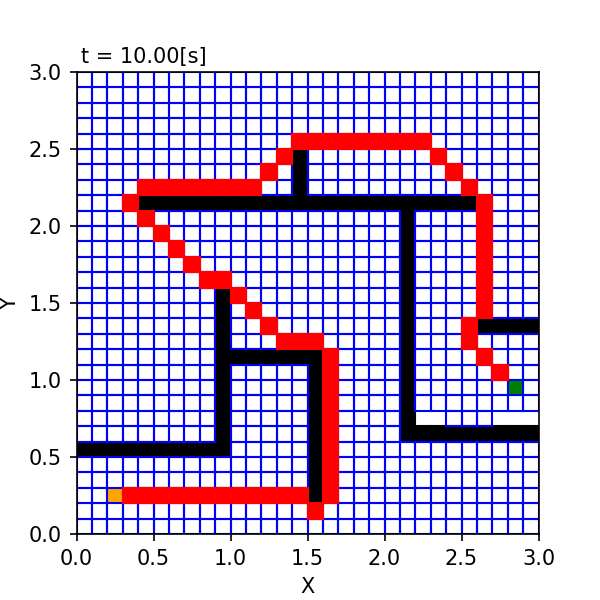

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.01
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(Dijkstra(world))
    
    world.draw()
    #world.ani.save('anm.gif', writer='pillow', fps=100)    #アニメーション保存